# Set up

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install transformers

     |████████████████████████████████| 675kB 4.8MB/s 
     |████████████████████████████████| 1.1MB 23.1MB/s 
     |████████████████████████████████| 890kB 31.4MB/s 
     |████████████████████████████████| 3.8MB 43.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=56dc99bdc42f858abd22399515da6e2a8600b28d1452414fc68f03dd5d0bd04e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# config.py

In [0]:
import os

import matplotlib
import matplotlib.pyplot as plt

import time

import torch
import transformers
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn
from torch.nn import Softmax

from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

from torch.autograd import Variable
import torch.nn.functional as F

warnings.filterwarnings("ignore")

class config:
    MAX_LEN = 192
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 3
    LEARNING_RATE = 1e-6
    BERT_PATH = "/content/gdrive/My Drive/bert-base-multilingual-uncased/"
    MODEL_PATH = "/content/gdrive/My Drive/model.bin"
    TOKENIZER = transformers.BertTokenizer.from_pretrained(
        BERT_PATH,
        do_lower_case=True
    )
    JIGSAW_DATA_PATH = "/content/gdrive/My Drive/"
    TRAINING_FILE_1 = os.path.join(
        JIGSAW_DATA_PATH, 
        "jigsaw-toxic-comment-train.csv"
    )
    TRAINING_FILE_2 = os.path.join(
        JIGSAW_DATA_PATH, 
        "jigsaw-unintended-bias-train.csv"
    )
    VALIDATION_FILE = os.path.join(
        JIGSAW_DATA_PATH, 
        "validation.csv"
    )

# dataset.py

In [0]:
class JigsawTraining:
    def __init__(self, comment_text, targets, config):
        self.comment_text = comment_text
        self.tokenizer = config.TOKENIZER
        self.max_length = config.MAX_LEN
        self.targets = targets

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, item):
        comment_text = str(self.comment_text[item])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]
        
        padding_length = self.max_length - len(ids)
        
        ids = ids + ([0] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[item], dtype=torch.float)
        }

# model.py

In [0]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, dropout=0.1, kernel_num=3, kernel_sizes=[2,3,4], num_labels=2):
        super().__init__()
        self.num_labels = num_labels
        self.embed_num = embed_num
        self.embed_dim = embed_dim
        self.dropout = dropout
        self.kernel_num = kernel_num
        self.kernel_sizes = kernel_sizes
        self.embed = nn.Embedding(self.embed_num, self.embed_dim)
        self.convs = nn.ModuleList([nn.Conv2d(1, self.kernel_num, (k, self.embed_dim)) for k in self.kernel_sizes])
        self.dropout = nn.Dropout(self.dropout)
        self.classifier = nn.Linear(len(self.kernel_sizes)*self.kernel_num, self.num_labels)
        # self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs, labels=None):
        output = inputs.unsqueeze(1)
        output = [nn.functional.relu(conv(output)).squeeze(3) for conv in self.convs]
        output = [nn.functional.max_pool1d(i, i.size(2)).squeeze(2) for i in output]
        output = torch.cat(output, 1)
        output = self.dropout(output)
        logits = self.classifier(output)
        # myout = self.softmax(logits)[:,1]
        # myout = self.sigmoid(logits)[:,1]
        myout = self.sigmoid(logits)[:,0]
        
        return myout

In [0]:
embed_num = config.MAX_LEN 
embed_dim = 768
dropout = 0.5
kernel_num = 3
kernel_sizes = [2,3,4]
num_labels = 1

MX = KimCNN(embed_num, embed_dim, dropout=dropout, kernel_num=kernel_num, kernel_sizes=kernel_sizes, num_labels=num_labels)

In [15]:
device = torch.device("cuda")
basemodel = transformers.BertModel.from_pretrained(config.BERT_PATH)
basemodel.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(105879, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

# engine.py

In [0]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets)


def train_fn(data_loader, model, optimizer, device):
    model.train()

    train_losses = []

    for bi, d in enumerate(data_loader):
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets = d["targets"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)
    
        with torch.no_grad():
            inputs,_ = basemodel(
                ids,
                token_type_ids,
                mask
            )
        
        myout = model(inputs, targets)
        #print("my output ", myout[1:10])
        #print("true label ", targets[1:10])

        loss = loss_fn(myout, targets)

        if bi % 20 == 0:
            train_losses.append(loss)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()   
      
        if bi % 100 == 0:
            print(f'Batch Id={bi}, Train Loss={loss}')
    
    return train_losses


def eval_fn(data_loader, model, device):
    model.eval()

    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for bi, d in enumerate(data_loader):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets = d["targets"]

            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            with torch.no_grad():
                inputs,_ = basemodel(
                    ids,
                    token_type_ids,
                    mask
                )

            myout = model(inputs, targets)

            loss = loss_fn(myout, targets)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(myout.cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

# train.py

In [0]:
df_train1 = pd.read_csv(
    config.TRAINING_FILE_1, 
    usecols=["comment_text", "toxic"]
).fillna("none")

df_train2 = pd.read_csv(
    config.TRAINING_FILE_2, 
    usecols=["comment_text", "toxic"]
).fillna("none")

df_valid = pd.read_csv(config.VALIDATION_FILE)

df_train = pd.concat([df_train1, df_train2], axis=0).reset_index(drop=True)
df_train = df_train.sample(frac=1).reset_index(drop=True).head(200000)

df_train = df_train[:50000].reset_index(drop=True)
df_valid = df_valid[:50000].reset_index(drop=True)

train_targets = df_train[:50000].toxic.values
valid_targets = df_valid[:50000].toxic.values

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def run():
    train_dataset = JigsawTraining(
        comment_text=df_train.comment_text.values,
        targets=train_targets,
        config=config
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN_BATCH_SIZE,
        drop_last=True,
        num_workers=2
    )

    valid_dataset = JigsawTraining(
        comment_text=df_valid.comment_text.values,
        targets=valid_targets,
        config=config
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=config.VALID_BATCH_SIZE,
        drop_last=False,
        num_workers=1
    )

    device = torch.device("cuda")
    model = MX.to(device)
    
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            'params': [
                p for n, p in param_optimizer if not any(
                    nd in n for nd in no_decay
                )
            ], 
            'weight_decay': 0.001
        },
        {
            'params': [
                p for n, p in param_optimizer if any(
                    nd in n for nd in no_decay
                )
            ],
            'weight_decay': 0.0
        },
    ]

    num_train_steps = int(
        len(df_train) / config.TRAIN_BATCH_SIZE / config.EPOCHS
    )
    optimizer = AdamW(
        optimizer_parameters, 
        lr=config.LEARNING_RATE
    )
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    best_auc = 0
    for epoch in range(config.EPOCHS):
        start_time = time.time()

        train_losses = train_fn(
            train_data_loader, 
            model, 
            optimizer, 
            device
        )
        
        outputs, targets = eval_fn(
            valid_data_loader, 
            model, 
            device
        )

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        plt.plot(train_losses, label="Training loss")
        plt.legend()
        plt.title("Losses")
        plt.show();
         

        targets = np.array(targets) >= 0.5
        auc = metrics.roc_auc_score(targets, outputs)
        
        print(f'AUC={auc}')
        if auc > best_auc:
            torch.save(model.state_dict(), config.MODEL_PATH)
            best_auc = auc

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')

Batch Id=0, Train Loss=0.6934752464294434
Batch Id=100, Train Loss=0.6936923265457153
Batch Id=200, Train Loss=0.6932569146156311
Batch Id=300, Train Loss=0.6934196949005127
Batch Id=400, Train Loss=0.6931471824645996
Batch Id=500, Train Loss=0.693692147731781
Batch Id=600, Train Loss=0.6934196352958679
Batch Id=700, Train Loss=0.6931495666503906
Batch Id=800, Train Loss=0.6934195756912231
Batch Id=900, Train Loss=0.6936919689178467
Batch Id=1000, Train Loss=0.6931471824645996
Batch Id=1100, Train Loss=0.6936919093132019
Batch Id=1200, Train Loss=0.6934195160865784
Batch Id=1300, Train Loss=0.6939641237258911
Batch Id=1400, Train Loss=0.6934194564819336
Batch Id=1500, Train Loss=0.6942362785339355


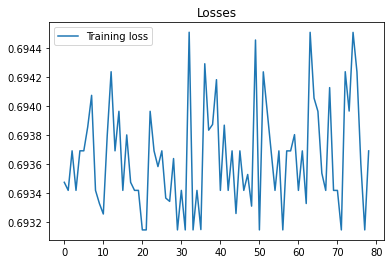

AUC=0.44136241908947893
Epoch: 01 | Epoch Time: 5m 38s
Batch Id=0, Train Loss=0.6933290958404541
Batch Id=100, Train Loss=0.694236159324646
Batch Id=200, Train Loss=0.6931471824645996
Batch Id=300, Train Loss=0.693419337272644
Batch Id=400, Train Loss=0.693419337272644
Batch Id=500, Train Loss=0.6940924525260925
Batch Id=600, Train Loss=0.6936914324760437
Batch Id=700, Train Loss=0.6934192776679993
Batch Id=800, Train Loss=0.6939634084701538
Batch Id=900, Train Loss=0.6938730478286743
Batch Id=1000, Train Loss=0.6936912536621094
Batch Id=1100, Train Loss=0.6934192180633545
Batch Id=1200, Train Loss=0.6945071220397949
Batch Id=1300, Train Loss=0.6931471824645996
Batch Id=1400, Train Loss=0.6933649778366089
Batch Id=1500, Train Loss=0.6931471824645996


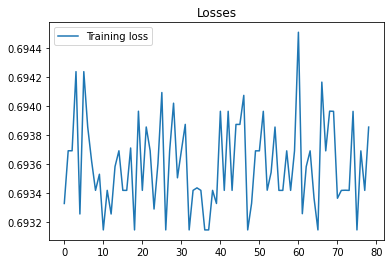

AUC=0.4413624791343926
Epoch: 02 | Epoch Time: 5m 38s
Batch Id=0, Train Loss=0.6933661103248596
Batch Id=100, Train Loss=0.6938738226890564
Batch Id=200, Train Loss=0.6936909556388855
Batch Id=300, Train Loss=0.6937834620475769
Batch Id=400, Train Loss=0.6934189796447754
Batch Id=500, Train Loss=0.6936907768249512
Batch Id=600, Train Loss=0.693872332572937
Batch Id=700, Train Loss=0.693583607673645
Batch Id=800, Train Loss=0.6939624547958374
Batch Id=900, Train Loss=0.6939623951911926
Batch Id=1000, Train Loss=0.6936905980110168
Batch Id=1100, Train Loss=0.6934188604354858
Batch Id=1200, Train Loss=0.6936905384063721
Batch Id=1300, Train Loss=0.6935163140296936
Batch Id=1400, Train Loss=0.6934479475021362
Batch Id=1500, Train Loss=0.6936002373695374


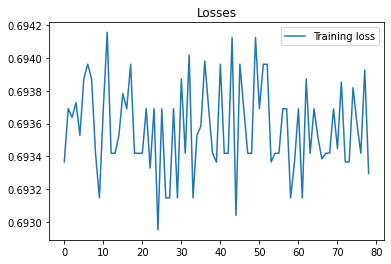

AUC=0.4413625992242198
Epoch: 03 | Epoch Time: 5m 38s


In [48]:
run()